In [ ]:
!pip install strawberryfields

# Hamiltonian Simulation

Simulation of physical quantum systems is an important application of quantum computation. There are some problems which are knows to be computationally hard for a classical computer - for example the notorious many-body problem in physics. For bosonic systems (and even single particle fermionic systems), the Continuous Variable model provides a suitable playground. Let us see how we can make a phtoonic quantum circuit to simulate the dynamics of a lattice-based system.

The Bose-Hubbard Model with onsite interations is defined by the Hamiltonian

$$\hat{H} = J\sum_{ij} (A_{ij}\hat{a}_i^\dagger\hat{a}_j + \mathrm{h.c.}) + \frac{1}{2}U\sum_i\hat{n}_i(\hat{n}_i - 1)$$

On a 2-site lattice, this reduces to
$$\hat{H} = J(\hat{a}_1^\dagger\hat{a}_2 + \hat{a}_2^\dagger\hat{a}_1) + \frac{1}{2}U(\hat{n}_1^2 -\hat{n}_1 + \hat{n}_2^2 - \hat{n}_2)$$

Here, $J$ represents the hopping amplitude of the boson between modes, and $U$ is the strength of the onsite interaction potential. $\hat{a}_1^\dagger\hat{a}_2$ talks about a boson hopping from site 1 to site 2, and its Hermitian conjugate talks about vice versa.

The Lie-Product formula is a useful approximation:
$$\exp(A+B) = \lim_{n \to \infty} (e^{A/n}e^{B/n})^n$$

The time evolution of a (time-independent) Hamiltonian is obtained by exponentiating it as follows:

$$\hat{U}(t, 0) = e^{-iH(t - 0)} = e^{-iHt}$$

We use this approximation to study the time evolution of the Hamiltonian of interest. Applying the Lie-Product formula to our Hamiltonian, we get:

$$e^{-iHt} = \Bigl[\exp\Bigl(-i\frac{Jt}{k}(\hat{a}_1^\dagger\hat{a}_2 + \hat{a}_2^\dagger\hat{a}_1)\Bigr)\exp\Bigl(-i\frac{Ut}{2k}\hat{n}_1^2\Bigr)\exp\Bigl(-i\frac{Ut}{2k}\hat{n}_2^2\Bigr)\exp\Bigl(-i\frac{Ut}{2k}\hat{n}_1\Bigr)\exp\Bigl(-i\frac{Ut}{2k}\hat{n}_2\Bigr)\Bigr]^k + \mathcal{O}(t^2/k)$$

we can compare this expression to those of the CV gates and write this in the form of beam-splitters, Kerr gates, and rotation gates.

We therefore have

$$e^{iHt} = [BS(\theta, \phi)(K(r)R(-r) \otimes K(r)R(-r))]^k + \mathcal{O}(t^2/k)$$

Where $\theta = -Jt/k, \phi = \pi/2$ and $r = -Ut/2k$

For k = 2, the circuit diagram would look like

 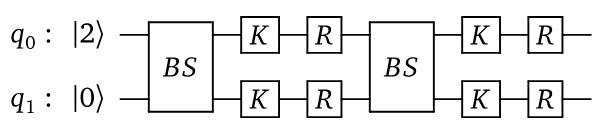

In [ ]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import *
import matplotlib.pyplot as plt

Now we define the parameters of the Hamiltonian

For the circuit, we need to define a `Program` object in Strawberry Fields, and populate the qumode registers using `with` and `prog.context` statements.


In [ ]:
ham_simulation = sf.Program(2)

# set the Hamiltonian parameters
J = 1           # hopping transition
U = 1.5         # on-site interaction
k = 20          # Lie product decomposition terms
t = 1.086       # timestep
theta = -J*t/k
r = -U*t/(2*k)

In [ ]:
with ham_simulation.context as q:
    # prepare the initial state
    Fock(2) | q[0]

    # Two node tight-binding
    # Hamiltonian simulation

    for i in range(k):
        BSgate(theta, np.pi/2) | (q[0], q[1])
        Kgate(r)  | q[0]
        Rgate(-r) | q[0]
        Kgate(r)  | q[1]
        Rgate(-r) | q[1]

To run this simulation, we will have to specify an `Engine`. Since we are working with initial states in the Fock basis, we will use the `Fock` backend, with a cutoff of 2 (which is sufficient since we are working with a single particle only).

In [ ]:
eng = sf.Engine(backend="fock", backend_options={"cutoff_dim": 5})
results = eng.run(ham_simulation)
state = results.state
print("P(|0, 2>) = ", state.fock_prob([0, 2]))
print("P(|1, 1>) = ", state.fock_prob([1, 1]))
print("P(|2, 0>) = ", state.fock_prob([2, 0]))

P(|0, 2>) =  0.5224012457200211
P(|1, 1>) =  0.23565287685672523
P(|2, 0>) =  0.24194587742326057


In [ ]:
result = [state.fock_prob([0, 2]), state.fock_prob([1, 1]), state.fock_prob([2, 0])]
print(np.sum(result))

1.0000000000000069


We can compare this result to the analytic matrix exponential $e^{-iHt}$, where we can compute the matrix elements of the Hamiltonian in the Fock basis.
This can be done by studying the action of the Hamiltonian on the basis states.

$$\langle 0, 2 | H | 0, 2 \rangle = \frac{1}{2}U\langle 0 | (\hat{n}^2 - \hat{n}) | 0 \rangle + \frac{1}{2}U\langle 2 | (\hat{n}^2 - \hat{n}) | 2 \rangle  = \frac{1}{2}U(2^2 - 2) = U$$

Similarly,

$$\langle 1, 1 | H | 1, 1 \rangle = 0$$
$$\langle 2, 0 | H | 2, 0 \rangle = U$$

And the hopping terms
$$\langle 1, 1 | H | 0, 2 \rangle = J \langle 1, 1 | (\hat{a}_1^\dagger\hat{a}-2 + \hat{a}_1\hat{a}_2^\dagger) | 0, 2 \rangle =
J(\sqrt{1}\sqrt{2} = \sqrt{0}\sqrt{3}) = J\sqrt{2}$$

$$\langle 1, 1 | H | 2, 0 \rangle = J\sqrt{2}$$

The above calculations and the property of Hermiticity of the Hamiltonian give us the final matrix form in the Fock basis as
$$ H = \begin{bmatrix} U & J\sqrt{2} & 0 \\
J\sqrt{2} & 0 & J\sqrt{2}\\
0 & J\sqrt{2} & U\end{bmatrix}$$

acting on the basis states $\{|0, 2\rangle, |1, 1\rangle, |2, 0\rangle\}$. To exponentiate this, we can use SciPy's `scipy.linalg.expm` function.

In [ ]:
from scipy.linalg import expm

H = J*np.sqrt(2)*np.array([[0,1,0],[1,0,1],[0,1,0]]) + U*np.diag([1,0,1])
init_state = np.array([0,0,1])

theoretical_result = np.abs(np.dot(expm(-1j*t*H), init_state))**2
print(theoretical_result)


[0.52249102 0.23516277 0.24234621]


In [ ]:
print(np.all(np.abs(theoretical_result - result) < 1e-2))

True


We have successfully simulated the Bose-Hubbard Hamiltonian for this small system on a photonic platform!

In [ ]:
# Hamiltonian parameters

J = 1 # hopping amplitude
U = 1.5 # on-site interaction strength
k = 100 # Lie product decomposition terms
timesteps = np.linspace(0, 2, 40)  # timestep

In [ ]:
# initialize the circuit
def circuit_at_timestep(J, U, k, timesteps):
  eng = sf.Engine(backend="fock", backend_options={"cutoff_dim": 2})

  # create an array to store probabilities
  probs = np.zeros((len(timesteps), 2))

  # Run the circuit for each timestep
  for t, time in enumerate(timesteps):
    #print("Step: ", t)

    # define a program with 2 qumodes for the two lattice sites
    ham_sim = sf.Program(2)
    theta = -J*time/k
    r = -U*time/(2*k)

    # prepare initial Fock state
    with ham_sim.context as q:
      Fock(1) | q[0]


    with ham_sim.context as q:
      # 2-mode tight-binding Hamiltonian
      for i in range(k):
        BSgate(theta, np.pi/2) | (q[0], q[1])
        Kgate(r) | q[0]
        Rgate(-r) | q[0]
        Kgate(r) | q[1]
        Rgate(-r) | q[1]

    result = eng.run(ham_sim)
    # Store the probabilities at each timestep
    probs[t, 0] = result.state.fock_prob([1, 0])
    probs[t, 1] = result.state.fock_prob([0, 1])

    # As a sanity check, we can see if the sum of probabilities at all timesteps adds up to 1
    #print(probs[t, 0] + probs[t, 1])

    eng.reset()

  return probs

In [ ]:
populations = circuit_at_timestep(J, U, k, timesteps)

array([0, 1])

In [ ]:
import seaborn as sns

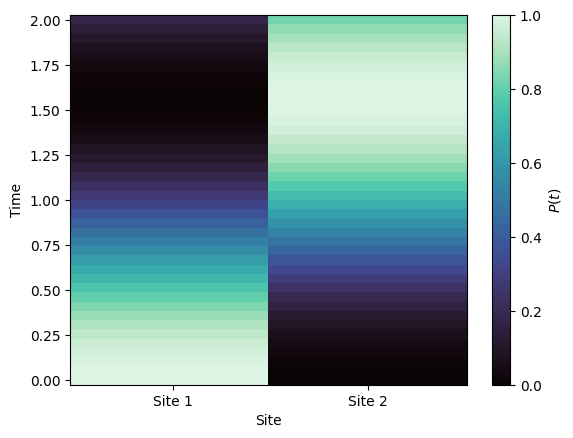

In [ ]:
# Make a plot of populations through time

sites = np.arange(0, 2, 1)

plt.pcolormesh(sites, timesteps, populations, cmap='mako')
plt.xlabel('Site')
plt.xticks(ticks=[0.02, 1], labels=['Site 1', 'Site 2'])
plt.ylabel('Time')
plt.colorbar(label=r'$P(t)$')